This notebook will guide you through loading the data, performing EDA, and normalizing the database.

In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from IPython.display import display

Step 1: Loading the data and Exploratory Data Analysis

In [40]:
DATA_DIR = 'data'
if not os.path.exists(DATA_DIR):
    print(f"Error: Data directory '{DATA_DIR}' not found. Please create it and place CSV files there.")

# Load data with memory optimization
common_dtypes = {
    'user_id': 'Int64', 
    'movie_id': 'Int64',
    'list_id': 'Int64',
    'rating_id': 'Int64',
    'movie_release_year': pd.Int64Dtype(),
    'user_trialist': pd.BooleanDtype(),
    'user_subscriber': pd.BooleanDtype(),
    'user_eligible_for_trial': pd.BooleanDtype(),
    'user_has_payment_method': pd.BooleanDtype(),
    'rating_score': 'float64',
    'list_movie_number': 'Int64', # Switched to Int64
    'list_followers': 'Int64',    # Switched to Int64
    'list_comments': 'Int64',     # Switched to Int64
    'movie_popularity': 'Int64'   # Switched to Int64
}

# Helper function to load CSV with specified dtypes and parse dates
def load_csv(filename, parse_dates_cols=None, use_cols=None):
    filepath = os.path.join(DATA_DIR, filename)
    try:
        # Determine which dtypes from common_dtypes apply to this file
        # First, get columns from CSV to avoid errors for non-existent columns in dtypes_spec
        preview_df = pd.read_csv(filepath, nrows=1)
        applicable_dtypes = {k: v for k, v in common_dtypes.items() if k in preview_df.columns}
        
        df = pd.read_csv(
            filepath,
            dtype=applicable_dtypes,
            parse_dates=parse_dates_cols,
            usecols=use_cols
        )
        print(f"Successfully loaded {filename}. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
    except Exception as e:
        print(f"Error loading {filename}: {e}")
    return None

In [41]:
# 1. Lists Data
# Kept: user_id, list_id, list_title, list_movie_number, list_update_timestamp_utc, list_creation_timestamp_utc, list_followers, list_comments
lists_cols_to_keep = ['user_id', 'list_id', 'list_title', 'list_movie_number', 'list_update_timestamp_utc', 'list_creation_timestamp_utc', 'list_followers', 'list_comments']
raw_lists_df = load_csv('mubi_lists_data.csv',
                        parse_dates_cols=['list_update_timestamp_utc', 'list_creation_timestamp_utc'],
                        use_cols=lists_cols_to_keep)

Successfully loaded mubi_lists_data.csv. Shape: (80311, 8)


In [42]:
# 2. Lists User Data
# Kept: user_id, list_id, user_trialist, user_subscriber, user_eligible_for_trial, user_has_payment_method
lists_users_cols_to_keep = ['user_id', 'list_id', 'user_trialist', 'user_subscriber', 'user_eligible_for_trial', 'user_has_payment_method']
raw_lists_users_df = load_csv('mubi_lists_user_data.csv',
                              use_cols=lists_users_cols_to_keep)

Successfully loaded mubi_lists_user_data.csv. Shape: (80311, 6)


In [43]:
# 3. Movie Data
# Kept: movie_id, movie_title, movie_release_year, movie_popularity, director_id, director_name
movies_cols_to_keep = ['movie_id', 'movie_title', 'movie_release_year', 'movie_popularity', 'director_id', 'director_name']
raw_movies_df = load_csv('mubi_movie_data.csv',
                         use_cols=movies_cols_to_keep)
if raw_movies_df is not None:
    raw_movies_df.dropna(subset=['movie_release_year', 'director_name', 'director_id'], inplace=True) # director_id added to dropna
    print(f"Shape of raw_movies_df after dropping NA in key columns: {raw_movies_df.shape}")


Successfully loaded mubi_movie_data.csv. Shape: (226575, 6)
Shape of raw_movies_df after dropping NA in key columns: (226567, 6)


In [44]:
# 4. Ratings Data
# Kept: movie_id, rating_id, rating_score, rating_timestamp_utc, user_id, user_trialist, user_subscriber, user_eligible_for_trial, user_has_payment_method
ratings_cols_to_keep = ['movie_id', 'rating_id', 'rating_score', 'rating_timestamp_utc', 'user_id', 'user_trialist', 'user_subscriber', 'user_eligible_for_trial', 'user_has_payment_method']
raw_ratings_df = load_csv('mubi_ratings_data.csv',
                          parse_dates_cols=['rating_timestamp_utc'],
                          use_cols=ratings_cols_to_keep)
if raw_ratings_df is not None:
    # Drop rows where essential information for a rating is missing
    ratings_dropna_subset = ['rating_id', 'movie_id', 'user_id', 'rating_score', 'rating_timestamp_utc']
    # Boolean flags can be NA, that's acceptable with BooleanDtype
    raw_ratings_df.dropna(subset=ratings_dropna_subset, inplace=True)
    print(f"Shape of raw_ratings_df after dropping NA in key columns: {raw_ratings_df.shape}")

Successfully loaded mubi_ratings_data.csv. Shape: (15520005, 9)
Shape of raw_ratings_df after dropping NA in key columns: (15493274, 9)


In [45]:
# 5. Ratings User Data (Daily User Status)
# Kept: user_id, rating_date_utc, user_trialist, user_subscriber, user_eligible_for_trial, user_has_payment_method
ratings_users_cols_to_keep = ['user_id', 'rating_date_utc', 'user_trialist', 'user_subscriber', 'user_eligible_for_trial', 'user_has_payment_method']
raw_ratings_users_df = load_csv('mubi_ratings_user_data.csv',
                                parse_dates_cols=['rating_date_utc'],
                                use_cols=ratings_users_cols_to_keep)
if raw_ratings_users_df is not None:
    # Drop rows where essential information for daily status is missing
    ratings_users_dropna_subset = ['user_id', 'rating_date_utc']
    raw_ratings_users_df.dropna(subset=ratings_users_dropna_subset, inplace=True)
    print(f"Shape of raw_ratings_users_df after dropping NA in key columns: {raw_ratings_users_df.shape}")

Successfully loaded mubi_ratings_user_data.csv. Shape: (4297641, 6)
Shape of raw_ratings_users_df after dropping NA in key columns: (4297641, 6)


In [46]:
# --- Display info for loaded DataFrames ---
dataframes = {
    "raw_lists_df": raw_lists_df,
    "raw_lists_users_df": raw_lists_users_df,
    "raw_movies_df": raw_movies_df,
    "raw_ratings_df": raw_ratings_df,
    "raw_ratings_users_df": raw_ratings_users_df
}

for name, df in dataframes.items():
    if df is not None:
        print(f"--- Info for {name} ---")
        df.info()
        display(df.head())
        print(f"Null values in {name}:\n{df.isnull().sum()}")
    else:
        print(f"{name} could not be loaded.")

--- Info for raw_lists_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80311 entries, 0 to 80310
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      80311 non-null  Int64         
 1   list_id                      80311 non-null  Int64         
 2   list_title                   80311 non-null  object        
 3   list_movie_number            80311 non-null  Int64         
 4   list_update_timestamp_utc    80311 non-null  datetime64[ns]
 5   list_creation_timestamp_utc  80311 non-null  datetime64[ns]
 6   list_followers               80311 non-null  Int64         
 7   list_comments                80311 non-null  Int64         
dtypes: Int64(5), datetime64[ns](2), object(1)
memory usage: 5.3+ MB


,user_id,list_id,list_title,list_movie_number,list_update_timestamp_utc,list_creation_timestamp_utc,list_followers,list_comments
0,85981819,1969,250 Favourite Films,250,2019-11-26 03:20:17,2009-12-18 13:04:48,23,5
1,85981819,3946,Films that should be better known,181,2020-05-01 05:54:39,2010-01-30 16:27:27,308,11
2,85981819,6683,Films by country (completely stolen from Glemaud),179,2020-04-12 08:31:35,2010-03-31 08:55:10,32,5
3,85981819,8865,Play it cool.,56,2018-12-14 14:53:41,2010-05-10 08:18:40,10,1
4,85981819,13796,Cinemalism (work in progress),121,2019-11-26 03:20:23,2010-08-25 14:23:56,43,3


Null values in raw_lists_df:
user_id                        0
list_id                        0
list_title                     0
list_movie_number              0
list_update_timestamp_utc      0
list_creation_timestamp_utc    0
list_followers                 0
list_comments                  0
dtype: int64
--- Info for raw_lists_users_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80311 entries, 0 to 80310
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  80311 non-null  Int64  
 1   list_id                  80311 non-null  Int64  
 2   user_trialist            80311 non-null  boolean
 3   user_subscriber          80311 non-null  boolean
 4   user_eligible_for_trial  80311 non-null  boolean
 5   user_has_payment_method  80311 non-null  boolean
dtypes: Int64(2), boolean(4)
memory usage: 2.0 MB


,user_id,list_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,85981819,1969,True,True,False,True
1,85981819,3946,True,True,False,True
2,85981819,6683,True,True,False,True
3,85981819,8865,True,True,False,True
4,85981819,13796,True,True,False,True


Null values in raw_lists_users_df:
user_id                    0
list_id                    0
user_trialist              0
user_subscriber            0
user_eligible_for_trial    0
user_has_payment_method    0
dtype: int64
--- Info for raw_movies_df ---
<class 'pandas.core.frame.DataFrame'>
Index: 226567 entries, 0 to 226574
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movie_id            226567 non-null  Int64 
 1   movie_title         226567 non-null  object
 2   movie_release_year  226567 non-null  Int64 
 3   movie_popularity    226567 non-null  Int64 
 4   director_id         226567 non-null  object
 5   director_name       226567 non-null  object
dtypes: Int64(3), object(3)
memory usage: 12.7+ MB


,movie_id,movie_title,movie_release_year,movie_popularity,director_id,director_name
0,1,La Antena,2007,105,131,Esteban Sapir
1,2,Elementary Particles,2006,23,73,Oskar Roehler
2,3,It's Winter,2006,21,82,Rafi Pitts
3,4,Kirikou and the Wild Beasts,2005,46,"89, 90","Michel Ocelot, Bénédicte Galup"
4,5,Padre Nuestro,2007,7,92,Christopher Zalla


Null values in raw_movies_df:
movie_id              0
movie_title           0
movie_release_year    0
movie_popularity      0
director_id           0
director_name         0
dtype: int64
--- Info for raw_ratings_df ---
<class 'pandas.core.frame.DataFrame'>
Index: 15493274 entries, 0 to 15520004
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   movie_id                 Int64         
 1   rating_id                Int64         
 2   rating_score             float64       
 3   rating_timestamp_utc     datetime64[ns]
 4   user_id                  Int64         
 5   user_trialist            boolean       
 6   user_subscriber          boolean       
 7   user_eligible_for_trial  boolean       
 8   user_has_payment_method  boolean       
dtypes: Int64(3), boolean(4), datetime64[ns](1), float64(1)
memory usage: 871.8 MB


,movie_id,rating_id,rating_score,rating_timestamp_utc,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,1066,15610495,3.0,2017-06-10 12:38:33,41579158,False,False,True,False
1,1066,10704606,2.0,2014-08-15 23:42:31,85981819,True,True,False,True
2,1066,10177114,2.0,2014-01-30 13:21:57,4208563,False,False,True,True
3,1066,10130280,3.0,2014-01-19 01:04:23,9820140,False,False,True,False
4,1066,8357049,4.0,2012-10-02 18:28:47,68654088,False,False,True,True


Null values in raw_ratings_df:
movie_id                   0
rating_id                  0
rating_score               0
rating_timestamp_utc       0
user_id                    0
user_trialist              3
user_subscriber            3
user_eligible_for_trial    3
user_has_payment_method    3
dtype: int64
--- Info for raw_ratings_users_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297641 entries, 0 to 4297640
Data columns (total 6 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   user_id                  Int64         
 1   rating_date_utc          datetime64[ns]
 2   user_trialist            boolean       
 3   user_subscriber          boolean       
 4   user_eligible_for_trial  boolean       
 5   user_has_payment_method  boolean       
dtypes: Int64(1), boolean(4), datetime64[ns](1)
memory usage: 102.5 MB


,user_id,rating_date_utc,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,41579158,2017-06-10,False,False,True,False
1,68654088,2012-10-02,False,False,True,True
2,84114365,2010-12-25,False,False,True,False
3,29755671,2010-11-15,False,False,True,False
4,93302487,2010-01-05,False,False,True,False


Null values in raw_ratings_users_df:
user_id                    0
rating_date_utc            0
user_trialist              3
user_subscriber            3
user_eligible_for_trial    3
user_has_payment_method    3
dtype: int64


Step 2: Normalization - Users Table

In [47]:
      
# Step 2: Normalize the dataset
# 2.1 Users Table

# Collect all unique user_ids from all relevant tables
all_user_ids = pd.Series(dtype='Int64')
if raw_lists_df is not None and 'user_id' in raw_lists_df.columns:
    all_user_ids = pd.concat([all_user_ids, raw_lists_df['user_id']])
if raw_ratings_df is not None and 'user_id' in raw_ratings_df.columns:
    all_user_ids = pd.concat([all_user_ids, raw_ratings_df['user_id']])
if raw_ratings_users_df is not None and 'user_id' in raw_ratings_users_df.columns:
    all_user_ids = pd.concat([all_user_ids, raw_ratings_users_df['user_id']])
# raw_lists_users_df also has user_id, ensure it's included if it might have unique users
if raw_lists_users_df is not None and 'user_id' in raw_lists_users_df.columns:
    all_user_ids = pd.concat([all_user_ids, raw_lists_users_df['user_id']])


if not all_user_ids.empty:
    unique_user_ids = all_user_ids.dropna().unique()
    Users_norm_df = pd.DataFrame(unique_user_ids, columns=['user_id']).astype({'user_id': 'Int64'})
    Users_norm_df.sort_values('user_id', inplace=True)
    Users_norm_df.reset_index(drop=True, inplace=True)
    print("--- Users_norm_df ---")
    Users_norm_df.info()
    display(Users_norm_df.head())
else:
    print("Could not create Users_norm_df as source dataframes are missing or empty.")
    Users_norm_df = None

--- Users_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451757 entries, 0 to 451756
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  451757 non-null  Int64
dtypes: Int64(1)
memory usage: 3.9 MB


,user_id
0,57
1,176
2,181
3,499
4,606


In [48]:
# 2.2 Movies Table
if raw_movies_df is not None:
    Movies_norm_df = raw_movies_df[['movie_id', 'movie_title', 'movie_release_year', 'movie_popularity']].copy()
    Movies_norm_df.drop_duplicates(subset=['movie_id'], inplace=True)
    Movies_norm_df.sort_values('movie_id', inplace=True)
    Movies_norm_df.reset_index(drop=True, inplace=True)
    print("--- Movies_norm_df ---")
    Movies_norm_df.info()
    display(Movies_norm_df.head())

    # 3.3 Directors and MovieDirectors Tables (Addressing 1NF for directors)
    # Ensure director_id and director_name are strings before splitting
    raw_movies_df['director_id'] = raw_movies_df['director_id'].astype(str)
    raw_movies_df['director_name'] = raw_movies_df['director_name'].astype(str)

    # Explode director_id
    movie_directors_id = raw_movies_df[['movie_id', 'director_id']].copy()
    movie_directors_id['director_id'] = movie_directors_id['director_id'].str.split(',')
    movie_directors_id_exploded = movie_directors_id.explode('director_id')
    movie_directors_id_exploded['director_id'] = movie_directors_id_exploded['director_id'].str.strip().astype('Int64') # Convert to Int64 after strip

    # Explode director_name
    movie_directors_name = raw_movies_df[['movie_id', 'director_name']].copy()
    movie_directors_name['director_name'] = movie_directors_name['director_name'].str.split(',')
    movie_directors_name_exploded = movie_directors_name.explode('director_name')
    movie_directors_name_exploded['director_name'] = movie_directors_name_exploded['director_name'].str.strip()

    # Create a common index for merging if lengths match (they should if data is consistent)
    # This assumes a 1:1 correspondence in the split lists of IDs and names for each movie
    
    # Let's create pairs of (director_id, director_name) first
    directors_list = []
    for _, row in raw_movies_df.iterrows():
        ids = [d_id.strip() for d_id in str(row['director_id']).split(',')]
        names = [d_name.strip() for d_name in str(row['director_name']).split(',')]
        
        # Handle cases where number of ids and names might not match, though ideally they should
        min_len = min(len(ids), len(names))
        for i in range(min_len):
            if ids[i] and names[i]: # Ensure non-empty id and name
                 # Attempt to convert director_id to Int64, handle potential errors
                try:
                    director_id_val = pd.NA if ids[i].lower() == 'nan' or not ids[i] else int(float(ids[i])) # Handle 'nan' strings or empty
                except ValueError:
                    director_id_val = pd.NA # Or some placeholder / logging
                
                if pd.notna(director_id_val):
                     directors_list.append({
                        'movie_id': row['movie_id'],
                        'director_id': director_id_val,
                        'director_name': names[i]
                    })

    MovieDirectors_temp_df = pd.DataFrame(directors_list)
    MovieDirectors_temp_df.dropna(subset=['director_id', 'director_name'], inplace=True)


    # Directors Table
    Directors_norm_df = MovieDirectors_temp_df[['director_id', 'director_name']].copy()
    Directors_norm_df.drop_duplicates(subset=['director_id'], inplace=True)
    Directors_norm_df.sort_values('director_id', inplace=True)
    Directors_norm_df.reset_index(drop=True, inplace=True)
    Directors_norm_df = Directors_norm_df.astype({'director_id': 'Int64', 'director_name': 'string'})


    print("--- Directors_norm_df ---")
    Directors_norm_df.info()
    display(Directors_norm_df.head())

    # MovieDirectors Junction Table
    MovieDirectors_norm_df = MovieDirectors_temp_df[['movie_id', 'director_id']].copy()
    MovieDirectors_norm_df.drop_duplicates(subset=['movie_id', 'director_id'], inplace=True)
    MovieDirectors_norm_df.sort_values(['movie_id', 'director_id'], inplace=True)
    MovieDirectors_norm_df.reset_index(drop=True, inplace=True)
    MovieDirectors_norm_df = MovieDirectors_norm_df.astype({'movie_id': 'Int64', 'director_id': 'Int64'})


    print("--- MovieDirectors_norm_df ---")
    MovieDirectors_norm_df.info()
    display(MovieDirectors_norm_df.head())

else:
    print("Could not create Movies/Directors tables as raw_movies_df is missing.")
    Movies_norm_df = None
    Directors_norm_df = None
    MovieDirectors_norm_df = None

--- Movies_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226567 entries, 0 to 226566
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movie_id            226567 non-null  Int64 
 1   movie_title         226567 non-null  object
 2   movie_release_year  226567 non-null  Int64 
 3   movie_popularity    226567 non-null  Int64 
dtypes: Int64(3), object(1)
memory usage: 7.6+ MB


,movie_id,movie_title,movie_release_year,movie_popularity
0,1,La Antena,2007,105
1,2,Elementary Particles,2006,23
2,3,It's Winter,2006,21
3,4,Kirikou and the Wild Beasts,2005,46
4,5,Padre Nuestro,2007,7


--- Directors_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99507 entries, 0 to 99506
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   director_id    99507 non-null  Int64 
 1   director_name  99507 non-null  string
dtypes: Int64(1), string(1)
memory usage: 1.6 MB


,director_id,director_name
0,27,Andrey Zvyagintsev
1,36,Michelangelo Antonioni
2,40,Ennio De Concini
3,45,Steve Cochran
4,46,Buster Keaton


--- MovieDirectors_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277739 entries, 0 to 277738
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   movie_id     277739 non-null  Int64
 1   director_id  277739 non-null  Int64
dtypes: Int64(2)
memory usage: 4.8 MB


,movie_id,director_id
0,1,131
1,2,73
2,3,82
3,4,89
4,4,90


In [49]:
# 2.4 Lists Table
if raw_lists_df is not None and raw_lists_users_df is not None:
    # Rename user_id in raw_lists_df to avoid clash and clarify it's the creator
    temp_lists_df = raw_lists_df.rename(columns={'user_id': 'creator_user_id'})

    # Merge with raw_lists_users_df to get user status at list creation
    # Assuming raw_lists_users_df.user_id is also the creator_user_id for that list_id
    # Perform a left merge to keep all lists, even if no matching user status (though ideally there should be)
    Lists_merged_df = pd.merge(
        temp_lists_df,
        raw_lists_users_df.rename(columns={'user_id': 'creator_user_id'}), # rename to match for merge
        on=['creator_user_id', 'list_id'],
        how='left'
    )

    # Select and rename columns for the final Lists_norm_df
    Lists_norm_df = Lists_merged_df[[
        'list_id', 'creator_user_id', 'list_title', 'list_movie_number',
        'list_creation_timestamp_utc', 'list_update_timestamp_utc',
        'list_followers', 'list_comments',
        'user_trialist', 'user_subscriber',
        'user_eligible_for_trial', 'user_has_payment_method'
    ]].copy()

    Lists_norm_df.rename(columns={
        'user_trialist': 'creator_trialist_at_creation',
        'user_subscriber': 'creator_subscriber_at_creation',
        'user_eligible_for_trial': 'creator_eligible_at_creation',
        'user_has_payment_method': 'creator_has_payment_at_creation'
    }, inplace=True)

    Lists_norm_df.drop_duplicates(subset=['list_id'], inplace=True) # list_id is PK
    Lists_norm_df.sort_values('list_id', inplace=True)
    Lists_norm_df.reset_index(drop=True, inplace=True)

    print("--- Lists_norm_df ---")
    Lists_norm_df.info()
    display(Lists_norm_df.head())
else:
    print("Could not create Lists_norm_df as source dataframes are missing.")
    Lists_norm_df = None

--- Lists_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80311 entries, 0 to 80310
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   list_id                          80311 non-null  Int64         
 1   creator_user_id                  80311 non-null  Int64         
 2   list_title                       80311 non-null  object        
 3   list_movie_number                80311 non-null  Int64         
 4   list_creation_timestamp_utc      80311 non-null  datetime64[ns]
 5   list_update_timestamp_utc        80311 non-null  datetime64[ns]
 6   list_followers                   80311 non-null  Int64         
 7   list_comments                    80311 non-null  Int64         
 8   creator_trialist_at_creation     80311 non-null  boolean       
 9   creator_subscriber_at_creation   80311 non-null  boolean       
 10  creator_eligible_at_creation     803

,list_id,creator_user_id,list_title,list_movie_number,list_creation_timestamp_utc,list_update_timestamp_utc,list_followers,list_comments,creator_trialist_at_creation,creator_subscriber_at_creation,creator_eligible_at_creation,creator_has_payment_at_creation
0,1,88260493,Films that made your kid sister cry,5,2009-11-11 00:02:21,2019-01-24 19:16:18,5,3,False,False,True,True
1,2,45204418,Headscratchers,3,2009-11-11 00:05:11,2018-12-03 15:12:20,1,2,True,True,False,False
2,3,48905025,Sexy Time Movies,7,2009-11-11 00:20:00,2019-05-30 03:00:07,6,5,False,False,True,False
3,4,74248012,TIFF09 Favorites,9,2009-11-11 00:21:57,2019-01-24 19:16:18,4,2,False,False,True,False
4,7,12074910,This is America,11,2009-11-11 00:32:52,2019-01-24 19:16:18,9,3,False,False,True,False


In [50]:
# 2.5 Ratings Table
if raw_ratings_df is not None:
    Ratings_norm_df = raw_ratings_df[[
        'rating_id', 'movie_id', 'user_id', 'rating_score', 'rating_timestamp_utc',
        'user_trialist', 'user_subscriber', 'user_eligible_for_trial', 'user_has_payment_method'
    ]].copy()

    Ratings_norm_df.rename(columns={
        'user_trialist': 'rater_trialist_at_rating',
        'user_subscriber': 'rater_subscriber_at_rating',
        'user_eligible_for_trial': 'rater_eligible_at_rating',
        'user_has_payment_method': 'rater_has_payment_at_rating'
    }, inplace=True)

    Ratings_norm_df.drop_duplicates(subset=['rating_id'], inplace=True) # rating_id is PK
    Ratings_norm_df.sort_values('rating_id', inplace=True)
    Ratings_norm_df.reset_index(drop=True, inplace=True)

    print("--- Ratings_norm_df ---")
    Ratings_norm_df.info()
    display(Ratings_norm_df.head())
else:
    print("Could not create Ratings_norm_df as raw_ratings_df is missing.")
    Ratings_norm_df = None

--- Ratings_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493266 entries, 0 to 15493265
Data columns (total 9 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   rating_id                    Int64         
 1   movie_id                     Int64         
 2   user_id                      Int64         
 3   rating_score                 float64       
 4   rating_timestamp_utc         datetime64[ns]
 5   rater_trialist_at_rating     boolean       
 6   rater_subscriber_at_rating   boolean       
 7   rater_eligible_at_rating     boolean       
 8   rater_has_payment_at_rating  boolean       
dtypes: Int64(3), boolean(4), datetime64[ns](1), float64(1)
memory usage: 753.6 MB


,rating_id,movie_id,user_id,rating_score,rating_timestamp_utc,rater_trialist_at_rating,rater_subscriber_at_rating,rater_eligible_at_rating,rater_has_payment_at_rating
0,2,35,49985304,4.0,2016-11-06 03:34:45,True,True,False,False
1,3,15,49985304,4.0,2016-11-06 03:36:48,True,True,False,False
2,4,24,49985304,3.0,2008-02-01 01:01:43,True,True,False,False
3,5,12,49985304,5.0,2008-02-01 01:01:45,True,True,False,False
4,7,3,49985304,3.0,2016-11-06 03:37:13,True,True,False,False


In [51]:
# 2.6 UserDailyStatus Table
if raw_ratings_users_df is not None:
    UserDailyStatus_norm_df = raw_ratings_users_df.copy()
    UserDailyStatus_norm_df.rename(columns={
        'rating_date_utc': 'status_date_utc',
        'user_trialist': 'trialist_on_date',
        'user_subscriber': 'subscriber_on_date',
        'user_eligible_for_trial': 'eligible_on_date',
        'user_has_payment_method': 'has_payment_on_date'
    }, inplace=True)

    # PK is (user_id, status_date_utc)
    UserDailyStatus_norm_df.drop_duplicates(subset=['user_id', 'status_date_utc'], inplace=True)
    UserDailyStatus_norm_df.sort_values(['user_id', 'status_date_utc'], inplace=True)
    UserDailyStatus_norm_df.reset_index(drop=True, inplace=True)
    
    print("--- UserDailyStatus_norm_df ---")
    UserDailyStatus_norm_df.info()
    display(UserDailyStatus_norm_df.head())
else:
    print("Could not create UserDailyStatus_norm_df as raw_ratings_users_df is missing.")
    UserDailyStatus_norm_df = None

--- UserDailyStatus_norm_df ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297641 entries, 0 to 4297640
Data columns (total 6 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              Int64         
 1   status_date_utc      datetime64[ns]
 2   trialist_on_date     boolean       
 3   subscriber_on_date   boolean       
 4   eligible_on_date     boolean       
 5   has_payment_on_date  boolean       
dtypes: Int64(1), boolean(4), datetime64[ns](1)
memory usage: 102.5 MB


,user_id,status_date_utc,trialist_on_date,subscriber_on_date,eligible_on_date,has_payment_on_date
0,57,2010-03-15,False,False,True,False
1,176,2019-02-13,False,False,True,True
2,176,2019-02-16,False,False,True,True
3,176,2019-02-17,False,False,True,True
4,176,2019-02-18,False,False,True,True


Step 3: Store Normalized Tables into SQLite Database

In [52]:
# Storing normalized data

DB_NAME = 'mubi_normalized.db'
if os.path.exists(DB_NAME):
    os.remove(DB_NAME) # Remove DB if it exists to start fresh

conn = sqlite3.connect(DB_NAME)
print(f"Connected to SQLite database: {DB_NAME}")

normalized_tables = {
    "Users": Users_norm_df,
    "Movies": Movies_norm_df,
    "Directors": Directors_norm_df,
    "MovieDirectors": MovieDirectors_norm_df,
    "Lists": Lists_norm_df,
    "Ratings": Ratings_norm_df,
    "UserDailyStatus": UserDailyStatus_norm_df
}

for table_name, df in normalized_tables.items():
    if df is not None:
        try:
            # Convert Pandas nullable types to types SQLite can handle before saving
            # BooleanDtype -> INTEGER (0 or 1)
            # Int64Dtype -> INTEGER
            # string -> TEXT
            df_sqlite = df.copy()
            for col in df_sqlite.columns:
                if pd.api.types.is_bool_dtype(df_sqlite[col]): # Catches BooleanDtype
                    df_sqlite[col] = df_sqlite[col].astype('object').where(df_sqlite[col].notna(), None) # Keep True/False, map NA to None
                    # SQLite will store True as 1, False as 0
                elif pd.api.types.is_integer_dtype(df_sqlite[col]) and not isinstance(df_sqlite[col].dtype, pd.Int64Dtype):
                     # Standard int, no change needed unless it has NAs not handled by Int64Dtype
                     pass # Standard int types are fine
                elif isinstance(df_sqlite[col].dtype, pd.Int64Dtype): # Pandas nullable integer
                    df_sqlite[col] = df_sqlite[col].astype('object').where(df_sqlite[col].notna(), None) # Convert NA to None for SQLite
                elif pd.api.types.is_string_dtype(df_sqlite[col]) and isinstance(df_sqlite[col].dtype, pd.StringDtype): # Pandas string
                     df_sqlite[col] = df_sqlite[col].astype('object').where(df_sqlite[col].notna(), None)

            df_sqlite.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"Table '{table_name}' created and data inserted successfully.")
        except Exception as e:
            print(f"Error writing table {table_name} to SQLite: {e}")
    else:
        print(f"DataFrame for table '{table_name}' is None, skipping.")

# Verify tables in SQLite
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("\nTables in the database:")
for table in cursor.fetchall():
    print(table[0])
    # Optionally print schema for each table
    # cursor.execute(f"PRAGMA table_info({table[0]});")
    # print(f"Schema for {table[0]}: {cursor.fetchall()}")

conn.close()
print("SQLite connection closed.")

Connected to SQLite database: mubi_normalized.db
Table 'Users' created and data inserted successfully.
Table 'Movies' created and data inserted successfully.
Table 'Directors' created and data inserted successfully.
Table 'MovieDirectors' created and data inserted successfully.
Table 'Lists' created and data inserted successfully.
Table 'Ratings' created and data inserted successfully.
Table 'UserDailyStatus' created and data inserted successfully.

Tables in the database:
Users
Movies
Directors
MovieDirectors
Lists
Ratings
UserDailyStatus
SQLite connection closed.


Connect to DB and helper functio

In [53]:
# Connect to the SQLite database
DB_NAME = 'mubi_normalized.db'
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Helper function to execute query and display results as a DataFrame
def execute_query_to_df(query, connection):
    try:
        df = pd.read_sql_query(query, connection)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

print(f"Successfully connected to {DB_NAME}")

Successfully connected to mubi_normalized.db


### Question 1: Top Directors by Average Movie Rating

**Question:** "Which directors have the highest average movie rating for their films, considering only directors with at least 3 movies rated on the platform and movies with at least 20 ratings? List the top 10."

**Rationale:** This helps identify directors whose films are consistently well-received by the MUBI audience. This information can guide content acquisition strategies (e.g., acquiring more films from these directors, securing rights for their upcoming work) or inform "Director Spotlight" features to promote high-quality content. The thresholds (3 movies per director, 20 ratings per movie) ensure a degree of statistical significance.


In [54]:
query_q1 = """
WITH DirectorMovieRatings AS (
    -- Calculate average rating and rating count for each movie
    SELECT
        m.movie_id,
        m.movie_title,
        r.movie_id AS r_movie_id, -- for join
        AVG(r.rating_score) AS avg_movie_rating,
        COUNT(r.rating_id) AS num_ratings_for_movie
    FROM Movies m
    JOIN Ratings r ON m.movie_id = r.movie_id
    GROUP BY m.movie_id, m.movie_title
    HAVING COUNT(r.rating_id) >= 20 -- Only movies with at least 20 ratings
),
DirectorAggregatedStats AS (
    -- Aggregate ratings for each director
    SELECT
        d.director_id,
        d.director_name,
        AVG(dmr.avg_movie_rating) AS avg_director_rating,
        COUNT(DISTINCT dmr.movie_id) AS num_movies_by_director
    FROM Directors d
    JOIN MovieDirectors md ON d.director_id = md.director_id
    JOIN DirectorMovieRatings dmr ON md.movie_id = dmr.movie_id -- Use movie_id from DirectorMovieRatings for join
    GROUP BY d.director_id, d.director_name
    HAVING COUNT(DISTINCT dmr.movie_id) >= 3 -- Only directors with at least 3 rated movies (that meet the 20 ratings criteria)
)
SELECT
    director_name,
    avg_director_rating,
    num_movies_by_director
FROM DirectorAggregatedStats
ORDER BY avg_director_rating DESC, num_movies_by_director DESC
LIMIT 10;
"""

print("--- Q1: Top Directors by Average Movie Rating ---")
q1_df = execute_query_to_df(query_q1, conn)
display(q1_df)

--- Q1: Top Directors by Average Movie Rating ---


,director_name,avg_director_rating,num_movies_by_director
0,Usmar Ismail,4.327253,3
1,Pierre Perrault,4.318925,3
2,Shinsuke Ogawa,4.298137,5
3,Allan King,4.280662,6
4,Marlon Riggs,4.275794,3
5,Kidlat Tahimik,4.252643,4
6,Shyam Benegal,4.237332,7
7,Becky Martin,4.236592,4
8,Mikhail Kalik,4.224658,3
9,Teguh Karya,4.222832,4


### Question 2: Most Popular Movies by Number of Ratings

**Question:** "What are the top 10 movies that have received the most ratings?"

**Rationale:** Movies with a high volume of ratings indicate high engagement and visibility on the platform. These are films that users are actively watching and forming opinions on. The Content Strategy Director can use this to understand current high-traffic content, potentially for promotional tie-ins or to ensure these popular titles remain available.

In [55]:
query_q2 = """
SELECT
    m.movie_title,
    m.movie_release_year,
    COUNT(r.rating_id) AS total_ratings
FROM Movies m
JOIN Ratings r ON m.movie_id = r.movie_id
GROUP BY m.movie_id, m.movie_title, m.movie_release_year
ORDER BY total_ratings DESC
LIMIT 10;
"""

print("--- Q2: Most Popular Movies by Number of Ratings ---")
q2_df = execute_query_to_df(query_q2, conn)
display(q2_df)

--- Q2: Most Popular Movies by Number of Ratings ---


,movie_title,movie_release_year,total_ratings
0,Pulp Fiction,1994,41435
1,A Clockwork Orange,1971,34738
2,Fight Club,1999,34420
3,Eternal Sunshine of the Spotless Mind,2004,33969
4,The Shining,1980,32221
5,The Dark Knight,2008,30382
6,The Godfather,1972,30120
7,2001: A Space Odyssey,1968,30050
8,The Big Lebowski,1998,29828
9,Taxi Driver,1976,29731


### Question 3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies

**Question:** "For the top 5 most popular movies (by `movie_popularity` score from the `Movies` table), what is the average rating given by users who were subscribers at the time of rating versus those who were not?"

**Rationale:** This helps the Content Strategy Director understand if subscriber taste aligns with general "buzz" or catalog-defined popularity. It can reveal if highly popular movies are particularly well-received (or not) by the paying user base, which is crucial for retention and content valuation.

In [56]:
query_q3 = """
WITH TopPopularMovies AS (
    SELECT
        movie_id,
        movie_title,
        movie_popularity
    FROM Movies
    ORDER BY movie_popularity DESC
    LIMIT 5
)
SELECT
    tpm.movie_title,
    tpm.movie_popularity,
    CASE
        WHEN r.rater_subscriber_at_rating = 1 THEN 'Subscriber'
        WHEN r.rater_subscriber_at_rating = 0 THEN 'Non-Subscriber'
        ELSE 'Unknown' -- Handles potential NULLs if BooleanDtype wasn't strictly 0/1
    END AS rater_status,
    AVG(r.rating_score) AS average_rating,
    COUNT(r.rating_id) AS number_of_ratings
FROM TopPopularMovies tpm
JOIN Ratings r ON tpm.movie_id = r.movie_id
GROUP BY tpm.movie_id, tpm.movie_title, tpm.movie_popularity, rater_status -- Group by movie_id as well for correctness
ORDER BY tpm.movie_popularity DESC, tpm.movie_title, rater_status;
"""
# Note: rater_subscriber_at_rating is stored as 0 or 1 (or NULL) in SQLite.
# SQLite treats boolean TRUE as 1 and FALSE as 0.

print("--- Q3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies ---")
q3_df = execute_query_to_df(query_q3, conn)
display(q3_df)

--- Q3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies ---


,movie_title,movie_popularity,rater_status,average_rating,number_of_ratings
0,Pulp Fiction,13989,Non-Subscriber,4.397500,38478
1,Pulp Fiction,13989,Subscriber,4.310112,2957
2,2001: A Space Odyssey,13881,Non-Subscriber,4.482755,27399
3,2001: A Space Odyssey,13881,Subscriber,4.602414,2651
4,The Godfather,13103,Non-Subscriber,4.576023,27952
5,The Godfather,13103,Subscriber,4.558118,2168
6,A Clockwork Orange,12400,Non-Subscriber,4.345745,32093
7,A Clockwork Orange,12400,Subscriber,4.336862,2645
8,Taxi Driver,11591,Non-Subscriber,4.382377,27044
9,Taxi Driver,11591,Subscriber,4.410495,2687


### Question 4: Impact of Release Decade on Average Ratings

**Question:** "What is the average rating for movies grouped by their decade of release (e.g., 1950s, 1960s, ..., 2020s)? Only consider movies with at least 50 ratings."

**Rationale:** This analysis can reveal trends in audience preference for films from different eras (classic vs. contemporary). It can inform acquisition strategy by highlighting decades whose films perform well or are underserved. The 50-rating threshold per movie ensures that the average ratings are based on a reasonable number of opinions.

In [57]:
query_q4 = """
WITH MovieRatingStats AS (
    SELECT
        m.movie_id,
        m.movie_release_year,
        AVG(r.rating_score) AS avg_rating_for_movie,
        COUNT(r.rating_id) AS num_ratings_for_movie
    FROM Movies m
    JOIN Ratings r ON m.movie_id = r.movie_id
    GROUP BY m.movie_id, m.movie_release_year
    HAVING COUNT(r.rating_id) >= 50 -- Only movies with at least 50 ratings
)
SELECT
    (movie_release_year / 10) * 10 || 's' AS release_decade, -- Creates decade string like '1990s'
    AVG(avg_rating_for_movie) AS average_rating_for_decade,
    COUNT(DISTINCT movie_id) AS number_of_movies_in_decade,
    SUM(num_ratings_for_movie) AS total_ratings_in_decade
FROM MovieRatingStats
WHERE movie_release_year IS NOT NULL -- Ensure release year is present
GROUP BY release_decade
ORDER BY release_decade;
"""

print("--- Q4: Impact of Release Decade on Average Ratings ---")
q4_df = execute_query_to_df(query_q4, conn)
display(q4_df)

--- Q4: Impact of Release Decade on Average Ratings ---


,release_decade,average_rating_for_decade,number_of_movies_in_decade,total_ratings_in_decade
0,1870,3.994475,1,181
1,1880,3.185751,4,602
2,1890,3.326805,72,12151
3,1900,3.440873,80,23631
4,1910,3.505319,102,18474
5,1920,3.743136,310,159437
6,1930,3.659133,531,231725
7,1940,3.603727,621,354006
8,1950,3.620171,973,680540
9,1960,3.611015,1690,1094424


### Question 5: Most Active List Creators and Their Rating Behavior

**Question:** "Who are the top 5 users who have created the most lists? For these users, what is the average rating they typically give to movies?"

**Rationale:** Identifying "super curators" or highly engaged list creators can be valuable. Understanding their general rating tendencies (do they rate harshly, generously, or average?) can provide context to their curations. This might also identify potential community influencers or users for beta testing new curation features.

In [58]:
query_q5 = """
WITH TopListCreators AS (
    SELECT
        creator_user_id,
        COUNT(list_id) AS num_lists_created
    FROM Lists
    GROUP BY creator_user_id
    ORDER BY num_lists_created DESC
    LIMIT 5
),
UserAverageRatings AS (
    SELECT
        user_id,
        AVG(rating_score) AS avg_rating_given_by_user,
        COUNT(rating_id) AS num_ratings_by_user
    FROM Ratings
    GROUP BY user_id
)
SELECT
    tlc.creator_user_id AS user_id,
    u.user_id AS check_user_id, -- For joining with Users table if we had user names
    tlc.num_lists_created,
    COALESCE(uar.avg_rating_given_by_user, 'N/A') AS avg_rating_given,
    COALESCE(uar.num_ratings_by_user, 0) AS total_ratings_made
FROM TopListCreators tlc
LEFT JOIN UserAverageRatings uar ON tlc.creator_user_id = uar.user_id
LEFT JOIN Users u ON tlc.creator_user_id = u.user_id -- If Users table had more info like username
ORDER BY tlc.num_lists_created DESC;
"""
# Note: The Users table currently only has user_id. If it had usernames, we'd join to display that.
# For now, we'll just display the user_id.

print("--- Q5: Most Active List Creators and Their Rating Behavior ---")
q5_df = execute_query_to_df(query_q5, conn)
display(q5_df)

--- Q5: Most Active List Creators and Their Rating Behavior ---


,user_id,check_user_id,num_lists_created,avg_rating_given,total_ratings_made
0,17893708,17893708,1263,3.094894,6639
1,47147944,47147944,1097,3.288395,1439
2,18285316,18285316,434,3.359096,1902
3,61596227,61596227,330,3.313033,10328
4,26889326,26889326,308,3.385892,1928


Close Connection

In [59]:
# Close the connection when done
if conn:
    conn.close()
    print(f"SQLite connection to {DB_NAME} closed.")

SQLite connection to mubi_normalized.db closed.


---
## Corroborating Answers with Pandas

In this step, we will re-implement the five SQL queries using pandas to corroborate the results. We will load the normalized tables from the `mubi_normalized.db` SQLite database into pandas DataFrames.
---

In [60]:
# Connect to the SQLite database again
DB_NAME = 'mubi_normalized.db'
conn = sqlite3.connect(DB_NAME)
print(f"Connected to {DB_NAME} for loading tables into pandas.")

# Load all normalized tables into pandas DataFrames
try:
    Users_df = pd.read_sql_query("SELECT * FROM Users", conn)
    Movies_df = pd.read_sql_query("SELECT * FROM Movies", conn)
    Directors_df = pd.read_sql_query("SELECT * FROM Directors", conn)
    MovieDirectors_df = pd.read_sql_query("SELECT * FROM MovieDirectors", conn)
    Lists_df = pd.read_sql_query("SELECT * FROM Lists", conn)
    Ratings_df = pd.read_sql_query("SELECT * FROM Ratings", conn)
    UserDailyStatus_df = pd.read_sql_query("SELECT * FROM UserDailyStatus", conn)
    print("All normalized tables loaded into pandas DataFrames successfully.")

except Exception as e:
    print(f"Error loading tables from SQLite into pandas: {e}")
finally:
    if conn:
        conn.close()
        print(f"SQLite connection to {DB_NAME} closed after loading tables.")

# Display a sample of loaded data to verify
if 'Ratings_df' in locals(): # Check if Ratings_df was loaded
    print("\nSample of Ratings_df:")
    display(Ratings_df.head())
    Ratings_df.info()
if 'Movies_df' in locals():
    print("\nSample of Movies_df:")
    display(Movies_df.head())
    Movies_df.info()

Connected to mubi_normalized.db for loading tables into pandas.
All normalized tables loaded into pandas DataFrames successfully.
SQLite connection to mubi_normalized.db closed after loading tables.

Sample of Ratings_df:


,rating_id,movie_id,user_id,rating_score,rating_timestamp_utc,rater_trialist_at_rating,rater_subscriber_at_rating,rater_eligible_at_rating,rater_has_payment_at_rating
0,2,35,49985304,4.0,2016-11-06 03:34:45,1.0,1.0,0.0,0.0
1,3,15,49985304,4.0,2016-11-06 03:36:48,1.0,1.0,0.0,0.0
2,4,24,49985304,3.0,2008-02-01 01:01:43,1.0,1.0,0.0,0.0
3,5,12,49985304,5.0,2008-02-01 01:01:45,1.0,1.0,0.0,0.0
4,7,3,49985304,3.0,2016-11-06 03:37:13,1.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493266 entries, 0 to 15493265
Data columns (total 9 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   rating_id                    int64  
 1   movie_id                     int64  
 2   user_id                      int64  
 3   rating_score                 float64
 4   rating_timestamp_utc         object 
 5   rater_trialist_at_rating     float64
 6   rater_subscriber_at_rating   float64
 7   rater_eligible_at_rating     float64
 8   rater_has_payment_at_rating  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 1.0+ GB

Sample of Movies_df:


,movie_id,movie_title,movie_release_year,movie_popularity
0,1,La Antena,2007,105
1,2,Elementary Particles,2006,23
2,3,It's Winter,2006,21
3,4,Kirikou and the Wild Beasts,2005,46
4,5,Padre Nuestro,2007,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226567 entries, 0 to 226566
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movie_id            226567 non-null  int64 
 1   movie_title         226567 non-null  object
 2   movie_release_year  226567 non-null  int64 
 3   movie_popularity    226567 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.9+ MB


### Pandas Q1: Top Directors by Average Movie Rating
Corresponds to SQL Query 1.

In [61]:
print("--- Pandas Q1: Top Directors by Average Movie Rating ---")

if 'Movies_df' in locals() and 'Ratings_df' in locals() and 'Directors_df' in locals() and 'MovieDirectors_df' in locals():
    # Calculate average rating and rating count for each movie
    movie_ratings_stats = Ratings_df.groupby('movie_id').agg(
        avg_movie_rating=('rating_score', 'mean'),
        num_ratings_for_movie=('rating_id', 'count')
    ).reset_index()

    # Filter for movies with at least 20 ratings
    movie_ratings_stats_filtered = movie_ratings_stats[movie_ratings_stats['num_ratings_for_movie'] >= 20]

    # Merge with MovieDirectors to link movies to directors
    director_movie_ratings = pd.merge(MovieDirectors_df, movie_ratings_stats_filtered, on='movie_id')

    # Aggregate ratings for each director
    director_aggregated_stats = director_movie_ratings.groupby('director_id').agg(
        avg_director_rating=('avg_movie_rating', 'mean'),
        num_movies_by_director=('movie_id', 'nunique') # nunique for distinct movies
    ).reset_index()

    # Filter for directors with at least 3 rated movies (that met the 20 ratings criteria)
    director_aggregated_stats_filtered = director_aggregated_stats[director_aggregated_stats['num_movies_by_director'] >= 3]

    # Merge with Directors_df to get director names
    final_director_stats = pd.merge(director_aggregated_stats_filtered, Directors_df, on='director_id')

    # Select and order results
    q1_pandas_df = final_director_stats[['director_name', 'avg_director_rating', 'num_movies_by_director']] \
        .sort_values(by=['avg_director_rating', 'num_movies_by_director'], ascending=[False, False]) \
        .head(10)

    display(q1_pandas_df)
else:
    print("One or more required DataFrames (Movies_df, Ratings_df, Directors_df, MovieDirectors_df) not loaded.")

--- Pandas Q1: Top Directors by Average Movie Rating ---


,director_name,avg_director_rating,num_movies_by_director
3346,Usmar Ismail,4.327253,3
3022,Pierre Perrault,4.318925,3
2970,Shinsuke Ogawa,4.298137,5
2663,Allan King,4.280662,6
2798,Marlon Riggs,4.275794,3
3198,Kidlat Tahimik,4.252643,4
1633,Shyam Benegal,4.237332,7
4382,Becky Martin,4.236592,4
3436,Mikhail Kalik,4.224658,3
3255,Teguh Karya,4.222832,4


### Pandas Q2: Most Popular Movies by Number of Ratings
Corresponds to SQL Query 2.

In [62]:
print("--- Pandas Q2: Most Popular Movies by Number of Ratings ---")

if 'Movies_df' in locals() and 'Ratings_df' in locals():
    # Count ratings for each movie
    movie_rating_counts = Ratings_df.groupby('movie_id').agg(
        total_ratings=('rating_id', 'count')
    ).reset_index()

    # Merge with Movies_df to get movie titles and release years
    popular_movies = pd.merge(movie_rating_counts, Movies_df[['movie_id', 'movie_title', 'movie_release_year']], on='movie_id')

    # Select relevant columns and sort
    q2_pandas_df = popular_movies[['movie_title', 'movie_release_year', 'total_ratings']] \
        .sort_values(by='total_ratings', ascending=False) \
        .head(10)

    display(q2_pandas_df)
else:
    print("One or more required DataFrames (Movies_df, Ratings_df) not loaded.")

--- Pandas Q2: Most Popular Movies by Number of Ratings ---


,movie_title,movie_release_year,total_ratings
128,Pulp Fiction,1994,41435
114,A Clockwork Orange,1971,34738
857,Fight Club,1999,34420
66,Eternal Sunshine of the Spotless Mind,2004,33969
366,The Shining,1980,32221
1609,The Dark Knight,2008,30382
447,The Godfather,1972,30120
266,2001: A Space Odyssey,1968,30050
282,The Big Lebowski,1998,29828
170,Taxi Driver,1976,29731


### Pandas Q3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies
Corresponds to SQL Query 3.

In [66]:
print("--- Pandas Q3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies ---")

if 'Movies_df' in locals() and 'Ratings_df' in locals():
    # Get top 5 popular movies
    top_popular_movies = Movies_df.sort_values(by='movie_popularity', ascending=False).head(5)

    # Merge with Ratings_df
    # Assuming it's 0 or 1 (or pd.NA) from SQLite:
    ratings_for_top_movies = pd.merge(top_popular_movies[['movie_id', 'movie_title', 'movie_popularity']],
                                      Ratings_df,
                                      on='movie_id')
    
    # Create rater_status column
    def map_status(val):
        if pd.isna(val):
            return 'Unknown'
        return 'Subscriber' if val == 1 else 'Non-Subscriber'

    ratings_for_top_movies['rater_status'] = ratings_for_top_movies['rater_subscriber_at_rating'].apply(map_status)

    # Group by movie and rater_status to calculate average rating and count
    q3_pandas_df = ratings_for_top_movies.groupby(['movie_id', 'movie_title', 'movie_popularity', 'rater_status']).agg(
        average_rating=('rating_score', 'mean'),
        number_of_ratings=('rating_id', 'count')
    ).reset_index() # Reset index to make grouped columns regular columns

    # Sort for presentation
    q3_pandas_df = q3_pandas_df.sort_values(by=['movie_popularity', 'movie_title', 'rater_status'], ascending=[False, True, True])
    
    display(q3_pandas_df)
else:
    print("One or more required DataFrames (Movies_df, Ratings_df) not loaded.")

--- Pandas Q3: Subscriber vs. Non-Subscriber Rating Behavior for Top Popular Movies ---


,movie_id,movie_title,movie_popularity,rater_status,average_rating,number_of_ratings
2,161,Pulp Fiction,13989,Non-Subscriber,4.397500,38478
3,161,Pulp Fiction,13989,Subscriber,4.310112,2957
6,303,2001: A Space Odyssey,13881,Non-Subscriber,4.482755,27399
7,303,2001: A Space Odyssey,13881,Subscriber,4.602414,2651
8,488,The Godfather,13103,Non-Subscriber,4.576023,27952
9,488,The Godfather,13103,Subscriber,4.558118,2168
0,147,A Clockwork Orange,12400,Non-Subscriber,4.345745,32093
1,147,A Clockwork Orange,12400,Subscriber,4.336862,2645
4,204,Taxi Driver,11591,Non-Subscriber,4.382377,27044
5,204,Taxi Driver,11591,Subscriber,4.410495,2687


### Pandas Q4: Impact of Release Decade on Average Ratings
Corresponds to SQL Query 4.

In [64]:
print("--- Pandas Q4: Impact of Release Decade on Average Ratings ---")

if 'Movies_df' in locals() and 'Ratings_df' in locals():
    # Calculate stats per movie
    movie_rating_stats = Ratings_df.groupby('movie_id').agg(
        avg_rating_for_movie=('rating_score', 'mean'),
        num_ratings_for_movie=('rating_id', 'count')
    ).reset_index()

    # Filter movies with at least 50 ratings
    movie_rating_stats_filtered = movie_rating_stats[movie_rating_stats['num_ratings_for_movie'] >= 50]

    # Merge with Movies_df to get release year
    movies_with_stats = pd.merge(movie_rating_stats_filtered, Movies_df[['movie_id', 'movie_release_year']], on='movie_id')
    
    # Drop rows where movie_release_year is NA before creating decade
    movies_with_stats.dropna(subset=['movie_release_year'], inplace=True)
    movies_with_stats['movie_release_year'] = movies_with_stats['movie_release_year'].astype(int) # Ensure it's int for division

    # Create release_decade column
    movies_with_stats['release_decade'] = (movies_with_stats['movie_release_year'] // 10 * 10).astype(str) + 's'
    
    # Group by decade and aggregate
    q4_pandas_df = movies_with_stats.groupby('release_decade').agg(
        average_rating_for_decade=('avg_rating_for_movie', 'mean'),
        number_of_movies_in_decade=('movie_id', 'nunique'),
        total_ratings_in_decade=('num_ratings_for_movie', 'sum')
    ).reset_index()

    # Sort by decade
    q4_pandas_df = q4_pandas_df.sort_values(by='release_decade')

    display(q4_pandas_df)
else:
    print("One or more required DataFrames (Movies_df, Ratings_df) not loaded.")

--- Pandas Q4: Impact of Release Decade on Average Ratings ---


,release_decade,average_rating_for_decade,number_of_movies_in_decade,total_ratings_in_decade
0,1870s,3.994475,1,181
1,1880s,3.185751,4,602
2,1890s,3.326805,72,12151
3,1900s,3.440873,80,23631
4,1910s,3.505319,102,18474
5,1920s,3.743136,310,159437
6,1930s,3.659133,531,231725
7,1940s,3.603727,621,354006
8,1950s,3.620171,973,680540
9,1960s,3.611015,1690,1094424


### Pandas Q5: Most Active List Creators and Their Rating Behavior
Corresponds to SQL Query 5.

In [65]:
print("--- Pandas Q5: Most Active List Creators and Their Rating Behavior ---")

if 'Lists_df' in locals() and 'Ratings_df' in locals() and 'Users_df' in locals():
    # Top 5 list creators
    top_list_creators = Lists_df.groupby('creator_user_id').agg(
        num_lists_created=('list_id', 'count')
    ).reset_index().sort_values(by='num_lists_created', ascending=False).head(5)

    # User average ratings
    user_average_ratings = Ratings_df.groupby('user_id').agg(
        avg_rating_given_by_user=('rating_score', 'mean'),
        num_ratings_by_user=('rating_id', 'count')
    ).reset_index()

    # Merge top list creators with their rating behavior
    # Renaming 'creator_user_id' to 'user_id' in top_list_creators for merging
    q5_pandas_df = pd.merge(
        top_list_creators.rename(columns={'creator_user_id': 'user_id'}),
        user_average_ratings,
        on='user_id',
        how='left' # Keep all top creators, even if they have no ratings
    )
    
    # Merge with Users_df (though it only has user_id, good for structure)
    # q5_pandas_df = pd.merge(q5_pandas_df, Users_df, on='user_id', how='left') # Optional if Users_df had more info

    # Handle potential NaNs if a top list creator has no ratings
    q5_pandas_df['avg_rating_given_by_user'] = q5_pandas_df['avg_rating_given_by_user'].fillna('N/A')
    q5_pandas_df['num_ratings_by_user'] = q5_pandas_df['num_ratings_by_user'].fillna(0).astype(int)
    
    # Rename columns to match SQL output for clarity
    q5_pandas_df.rename(columns={
        'user_id': 'user_id', # or 'creator_user_id' if preferred
        'avg_rating_given_by_user': 'avg_rating_given',
        'num_ratings_by_user': 'total_ratings_made'
    }, inplace=True)
    
    # Select and order
    q5_pandas_df = q5_pandas_df[['user_id', 'num_lists_created', 'avg_rating_given', 'total_ratings_made']] \
        .sort_values(by='num_lists_created', ascending=False)

    display(q5_pandas_df)
else:
    print("One or more required DataFrames (Lists_df, Ratings_df, Users_df) not loaded.")

--- Pandas Q5: Most Active List Creators and Their Rating Behavior ---


,user_id,num_lists_created,avg_rating_given,total_ratings_made
0,17893708,1263,3.094894,6639
1,47147944,1097,3.288395,1439
2,18285316,434,3.359096,1902
3,61596227,330,3.313033,10328
4,26889326,308,3.385892,1928


---
## (Part 2 of Mini-Project): Visualizations for Medium Article

This section generates plots to support the findings for the public-facing Medium article.
We'll use the pandas DataFrames loaded from the normalized SQLite database.
---

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save images if it doesn't exist
IMAGES_DIR = 'images'
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    print(f"Directory '{IMAGES_DIR}' created.")
else:
    print(f"Directory '{IMAGES_DIR}' already exists.")

# Set a consistent style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

Directory 'images' created.


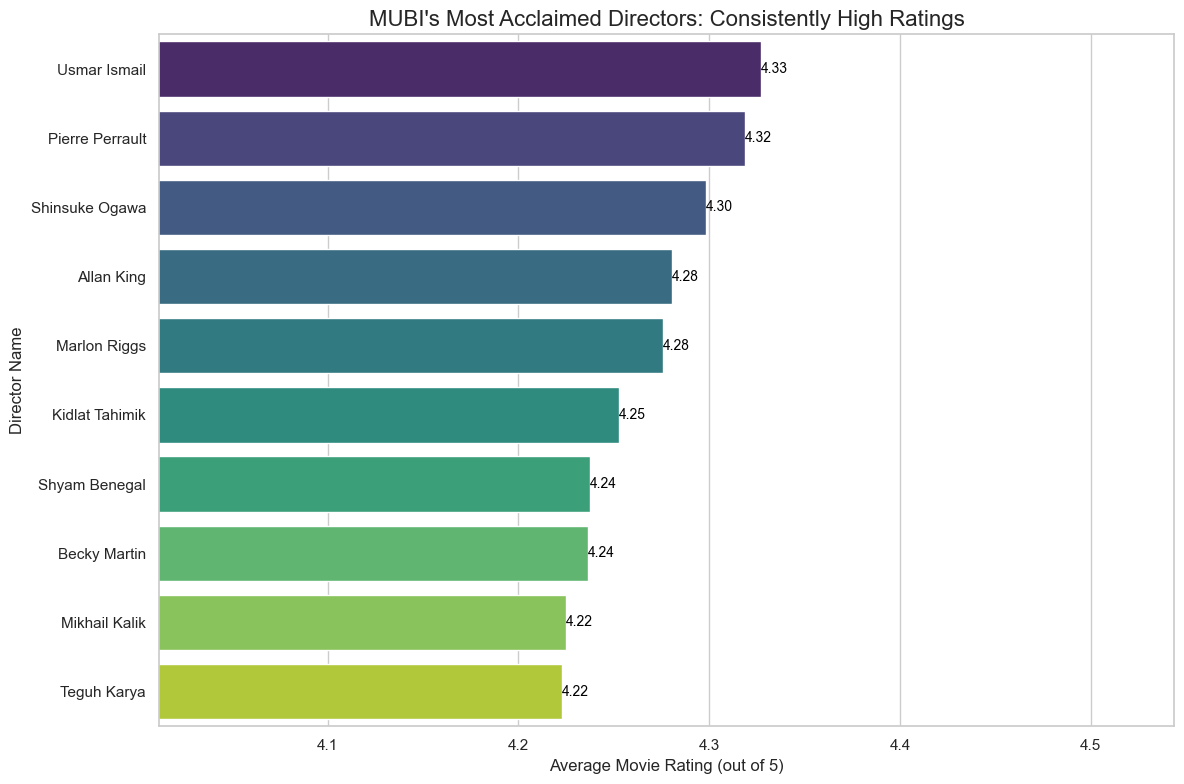

Plot for Finding 1 saved as 'top_directors_avg_rating.png'


In [74]:
# --- Plot for Finding 1: Top Directors by Average Movie Rating ---
if 'q1_pandas_df' in locals() and not q1_pandas_df.empty:
    plt.figure(figsize=(12, 8))
    # Ensure avg_director_rating is numeric
    q1_pandas_df['avg_director_rating'] = pd.to_numeric(q1_pandas_df['avg_director_rating'], errors='coerce')
    
    # Sort again just in case, as head(10) was already applied
    plot_df_q1 = q1_pandas_df.sort_values('avg_director_rating', ascending=False)

    barplot_q1 = sns.barplot(
        x='avg_director_rating',
        y='director_name',
        data=plot_df_q1,
        palette='viridis',
        hue='director_name', # Use hue to assign different colors if desired, or remove for single color palette
        dodge=False, # Set to False if hue is used for y-axis variable
        legend=False # Disable legend if hue is y-axis
    )
    plt.title('MUBI\'s Most Acclaimed Directors: Consistently High Ratings', fontsize=16)
    plt.xlabel('Average Movie Rating (out of 5)', fontsize=12)
    plt.ylabel('Director Name', fontsize=12)
    plt.xlim(plot_df_q1['avg_director_rating'].min() * 0.95 if not plot_df_q1.empty else 0, 
             plot_df_q1['avg_director_rating'].max() * 1.05 if not plot_df_q1.empty else 5) # Adjust xlim for better visualization

    # Add value labels to the bars
    for index, value in enumerate(plot_df_q1['avg_director_rating']):
        plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center", fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'top_directors_avg_rating.png'))
    plt.show()
    print("Plot for Finding 1 saved as 'top_directors_avg_rating.png'")
else:
    print("DataFrame q1_pandas_df is not available or empty. Skipping plot for Finding 1.")

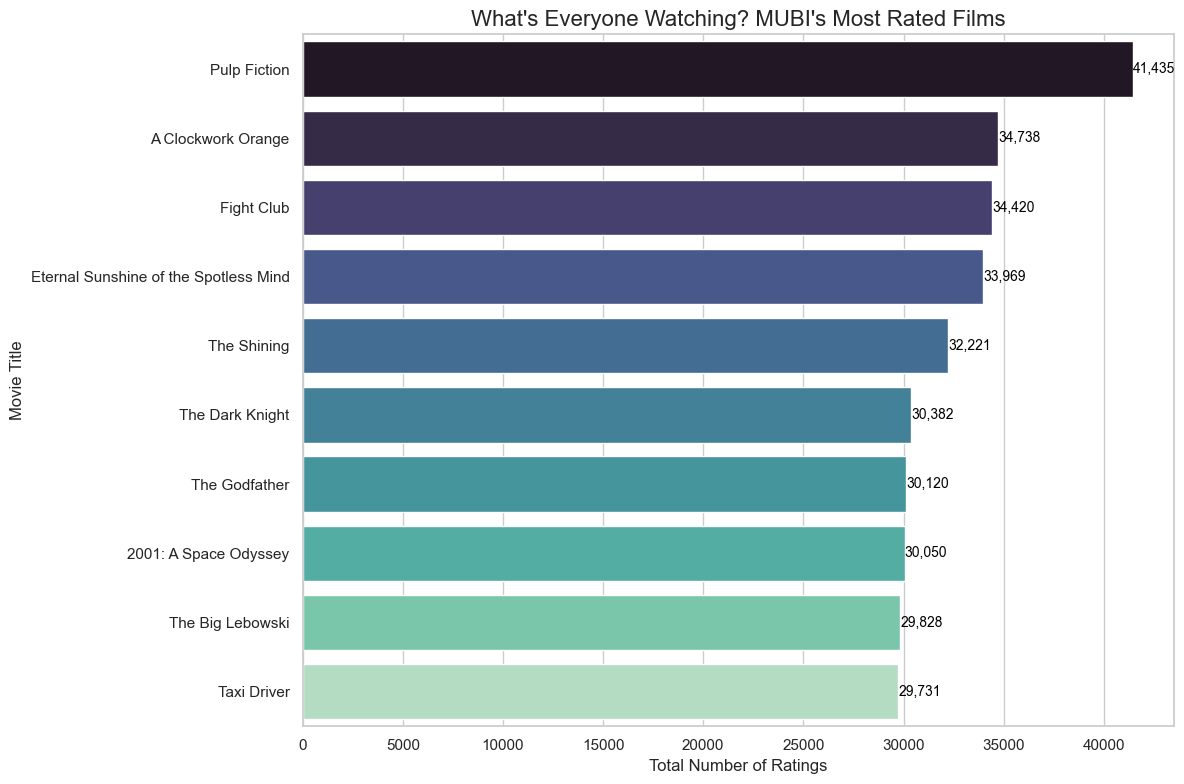

Plot for Finding 2 saved as 'most_rated_movies.png'


In [75]:
# --- Plot for Finding 2: Most Popular Movies by Number of Ratings ---
if 'q2_pandas_df' in locals() and not q2_pandas_df.empty:
    plt.figure(figsize=(12, 8))
    # Ensure total_ratings is numeric
    q2_pandas_df['total_ratings'] = pd.to_numeric(q2_pandas_df['total_ratings'], errors='coerce')
    
    plot_df_q2 = q2_pandas_df.sort_values('total_ratings', ascending=False)

    barplot_q2 = sns.barplot(
        x='total_ratings',
        y='movie_title',
        data=plot_df_q2,
        palette='mako',
        hue='movie_title',
        dodge=False,
        legend=False
    )
    plt.title('What\'s Everyone Watching? MUBI\'s Most Rated Films', fontsize=16)
    plt.xlabel('Total Number of Ratings', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)

    # Add value labels to the bars
    for index, value in enumerate(plot_df_q2['total_ratings']):
        plt.text(value, index, f'{int(value):,}', color='black', ha="left", va="center", fontsize=10)


    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'most_rated_movies.png'))
    plt.show()
    print("Plot for Finding 2 saved as 'most_rated_movies.png'")
else:
    print("DataFrame q2_pandas_df is not available or empty. Skipping plot for Finding 2.")

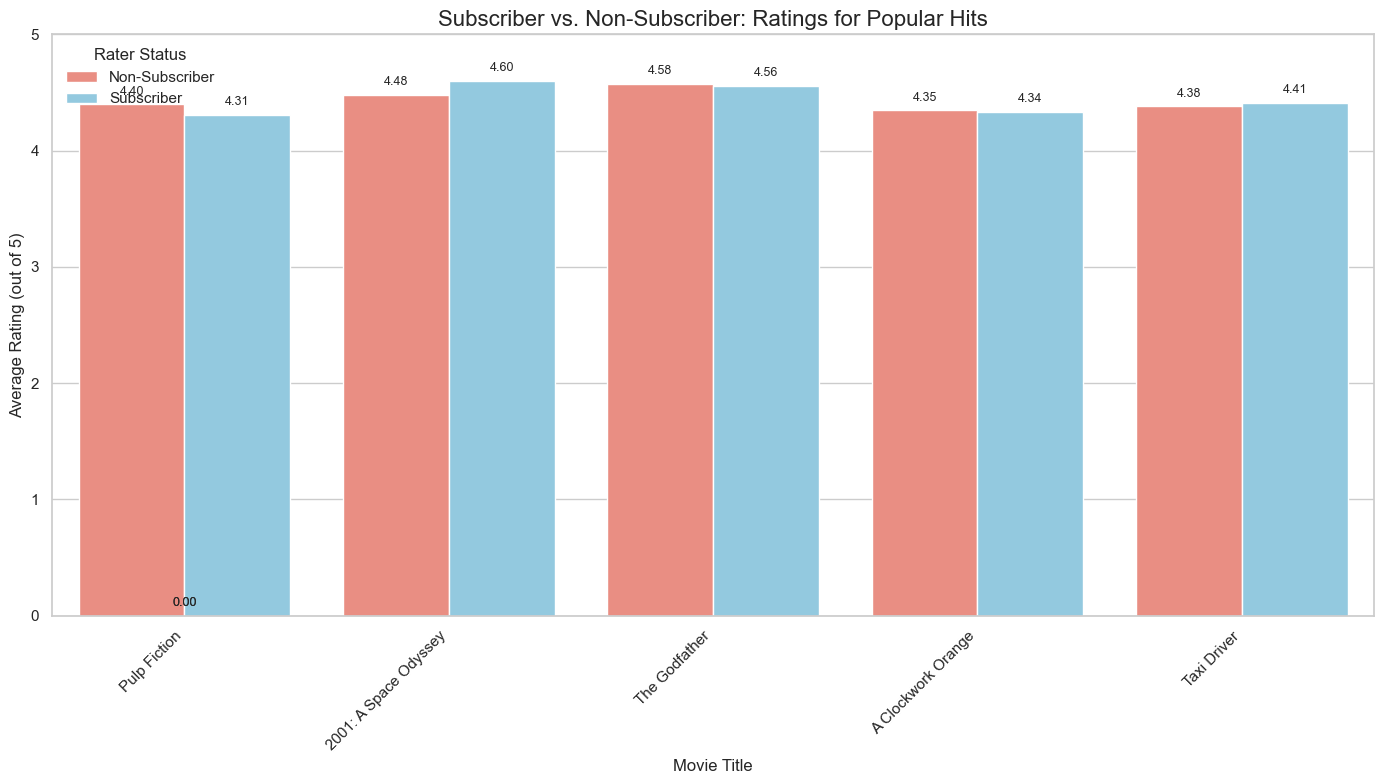

Plot for Finding 3 saved as 'subscriber_vs_non_subscriber_ratings.png'


In [76]:
# --- Plot for Finding 3: Subscriber vs. Non-Subscriber Rating Behavior ---
if 'q3_pandas_df' in locals() and not q3_pandas_df.empty:
    plt.figure(figsize=(14, 8))
    # Ensure average_rating is numeric
    q3_pandas_df['average_rating'] = pd.to_numeric(q3_pandas_df['average_rating'], errors='coerce')
    
    # Shorten movie titles if they are too long for better display
    q3_pandas_df['short_movie_title'] = q3_pandas_df['movie_title'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)

    barplot_q3 = sns.barplot(
        x='short_movie_title',
        y='average_rating',
        hue='rater_status',
        data=q3_pandas_df,
        palette={'Subscriber': 'skyblue', 'Non-Subscriber': 'salmon', 'Unknown': 'lightgray'}
    )
    plt.title('Subscriber vs. Non-Subscriber: Ratings for Popular Hits', fontsize=16)
    plt.xlabel('Movie Title', fontsize=12)
    plt.ylabel('Average Rating (out of 5)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 5) # Ratings are typically 1-5
    plt.legend(title='Rater Status')

    # Add value labels to the bars
    for p in barplot_q3.patches:
        barplot_q3.annotate(format(p.get_height(), '.2f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 9),
                           textcoords = 'offset points', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'subscriber_vs_non_subscriber_ratings.png'))
    plt.show()
    print("Plot for Finding 3 saved as 'subscriber_vs_non_subscriber_ratings.png'")
else:
    print("DataFrame q3_pandas_df is not available or empty. Skipping plot for Finding 3.")

/var/folders/5g/2tcry58x5170kjbn7zq7gp900000gn/T/ipykernel_14107/985865693.py:28: UserWarning: 
The palette list has fewer values (1) than needed (16) and will cycle, which may produce an uninterpretable plot.
  bars = sns.barplot(x='release_decade', y='number_of_movies_in_decade', data=q4_plot_df, ax=ax1, palette=[color_movies], hue='release_decade', dodge=False, legend=False)
/var/folders/5g/2tcry58x5170kjbn7zq7gp900000gn/T/ipykernel_14107/985865693.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=12)


Plot saved to plots/ratings_by_decade.png


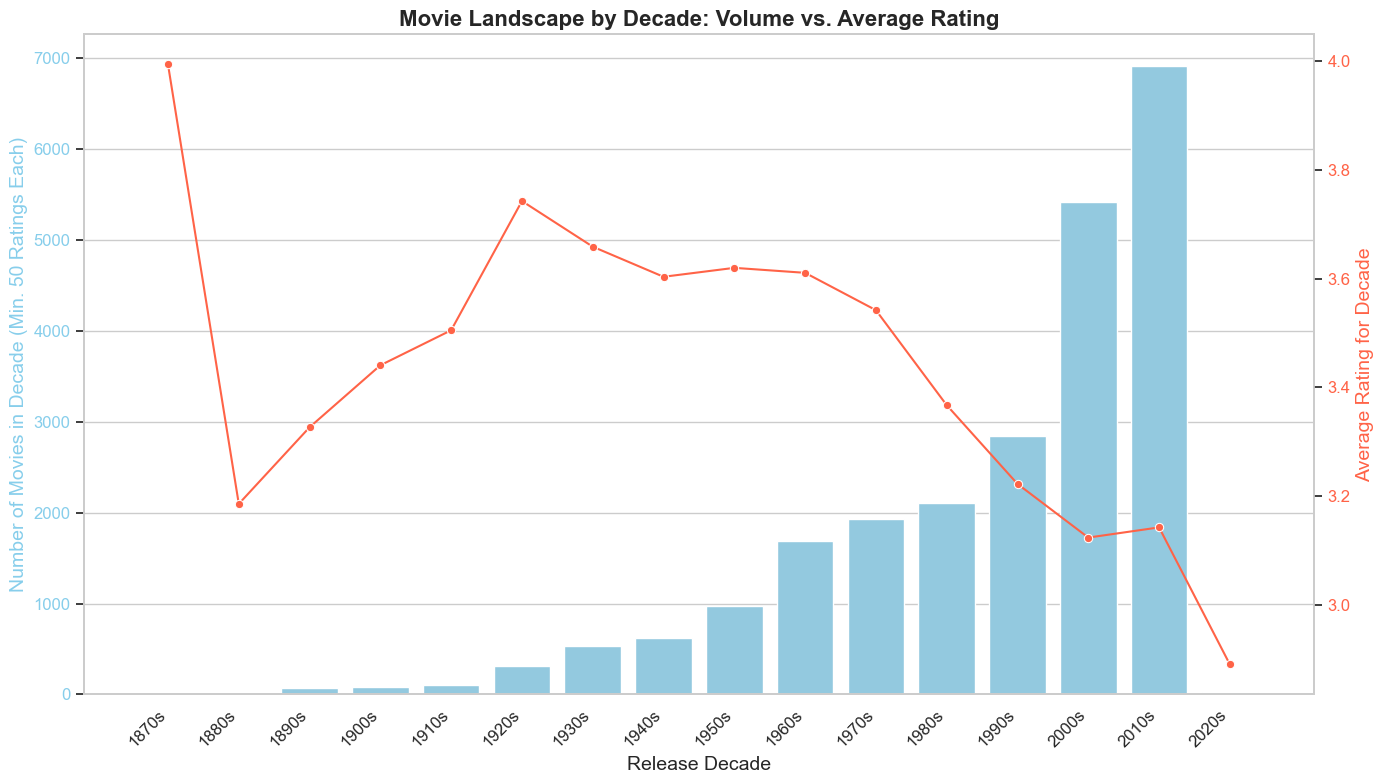

In [78]:
# VISUALIZATION FOR FINDING 4: Impact of Release Decade on Average Ratings

# Assuming q4_df (from SQL) or q4_pandas_df (from pandas) is available
if 'q4_pandas_df' in locals() and not q4_pandas_df.empty:
    # Ensure 'release_decade' is sorted correctly if it's treated as string
    # If 'release_decade' includes 's' (e.g., '1990s'), sort it as string.
    # For better chronological sorting, it's best if the decade is numeric first.
    # Let's assume q4_pandas_df['release_decade'] is like '1990s' and sortable as string for now.
    # If it's purely numeric like 1990, then sort numerically.
    
    # Filter out very old decades with few movies if they skew the plot too much
    # For example, if '1870s' has only 1 movie, it might not be representative.
    # This depends on your actual data from q4_pandas_df.
    # For now, we'll plot all decades returned by the query.
    
    q4_plot_df = q4_pandas_df.copy()
    # Convert 'release_decade' to an integer for proper sorting if it has 's'
    q4_plot_df['decade_sort_key'] = q4_plot_df['release_decade'].str.replace('s', '').astype(int)
    q4_plot_df = q4_plot_df.sort_values('decade_sort_key')


    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Bar plot for number of movies
    color_movies = 'skyblue'
    ax1.set_xlabel('Release Decade', fontsize=14)
    ax1.set_ylabel('Number of Movies in Decade (Min. 50 Ratings Each)', color=color_movies, fontsize=14)
    bars = sns.barplot(x='release_decade', y='number_of_movies_in_decade', data=q4_plot_df, ax=ax1, palette=[color_movies], hue='release_decade', dodge=False, legend=False)
    ax1.tick_params(axis='y', labelcolor=color_movies, labelsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=12)

    # Line plot for average rating on a secondary y-axis
    ax2 = ax1.twinx()
    color_rating = 'tomato'
    ax2.set_ylabel('Average Rating for Decade', color=color_rating, fontsize=14)
    sns.lineplot(x='release_decade', y='average_rating_for_decade', data=q4_plot_df, ax=ax2, color=color_rating, marker='o', sort=False) # sort=False because data is pre-sorted
    ax2.tick_params(axis='y', labelcolor=color_rating, labelsize=12)
    ax2.grid(False) # Turn off grid for the secondary axis if it's too busy

    plt.title('Movie Landscape by Decade: Volume vs. Average Rating', fontsize=16, fontweight='bold')
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    plot_path = os.path.join(PLOTS_DIR, 'ratings_by_decade.png')
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()
else:
    print("q4_pandas_df is not available or empty. Please run the corresponding query/pandas code first.")

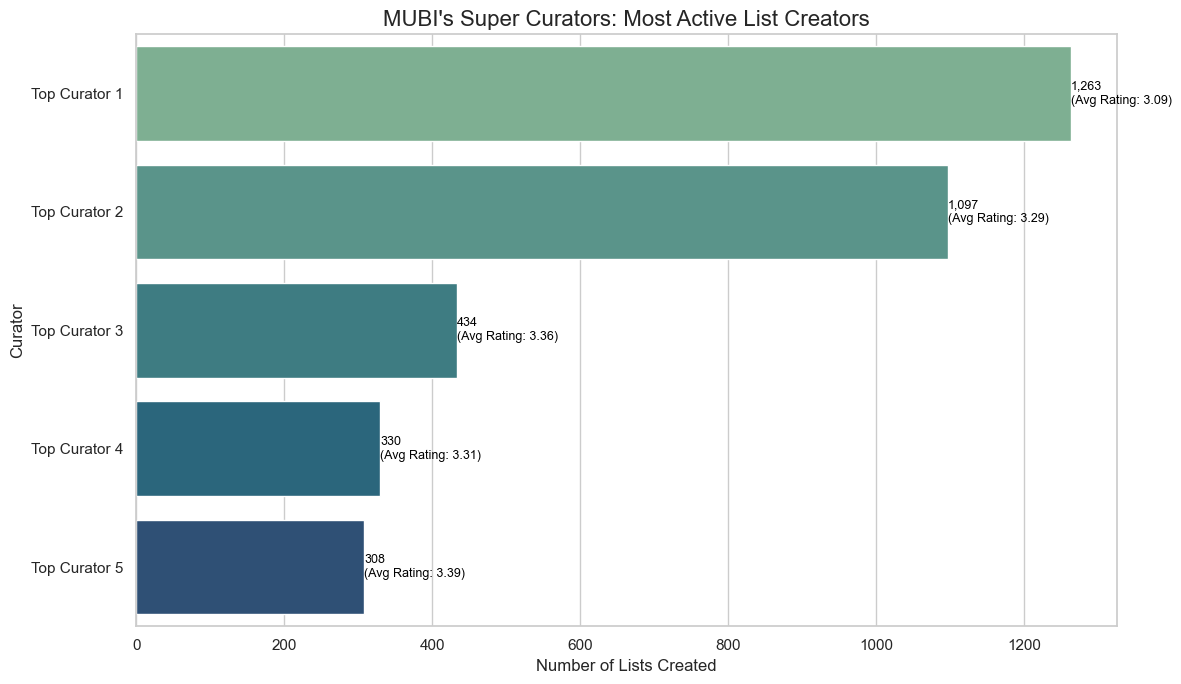

Plot for Finding 5 saved as 'top_list_creators.png'


In [79]:
# --- Plot for Finding 5: Most Active List Creators ---
if 'q5_pandas_df' in locals() and not q5_pandas_df.empty:
    plt.figure(figsize=(12, 7))
    # Ensure num_lists_created is numeric
    q5_pandas_df['num_lists_created'] = pd.to_numeric(q5_pandas_df['num_lists_created'], errors='coerce')
    
    # For privacy/readability in a public article, we'll use generic labels for user_ids
    plot_df_q5 = q5_pandas_df.copy()
    plot_df_q5['curator_label'] = [f'Top Curator {i+1}' for i in range(len(plot_df_q5))]
    
    # Also ensure avg_rating_given is numeric for annotation, handling 'N/A'
    plot_df_q5['avg_rating_given_numeric'] = pd.to_numeric(plot_df_q5['avg_rating_given'], errors='coerce')


    barplot_q5 = sns.barplot(
        x='num_lists_created',
        y='curator_label',
        data=plot_df_q5.sort_values('num_lists_created', ascending=False),
        palette='crest',
        hue='curator_label',
        dodge=False,
        legend=False
    )
    plt.title('MUBI\'s Super Curators: Most Active List Creators', fontsize=16)
    plt.xlabel('Number of Lists Created', fontsize=12)
    plt.ylabel('Curator', fontsize=12)

    # Annotate bars with number of lists and their average rating
    for index, row in plot_df_q5.sort_values('num_lists_created', ascending=False).reset_index().iterrows():
        num_lists = int(row['num_lists_created'])
        avg_rating_val = row['avg_rating_given_numeric']
        avg_rating_text = f'{avg_rating_val:.2f}' if pd.notna(avg_rating_val) else 'N/A'
        
        plt.text(num_lists, index, f'{num_lists:,}\n(Avg Rating: {avg_rating_text})',
                 color='black', ha="left", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'top_list_creators.png'))
    plt.show()
    print("Plot for Finding 5 saved as 'top_list_creators.png'")
else:
    print("DataFrame q5_pandas_df is not available or empty. Skipping plot for Finding 5.")